###  Modelo para extraer la edad de las cedulas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import re
from joblib import dump,load
from lightgbm import LGBMClassifier
import gc
import sys

In [2]:
#def usoMemoria():
    # These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    #print(usoM)

[('LGBMClassifier', 1064),
 ('dump', 136),
 ('load', 136),
 ('train_test_split', 136),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('sns', 72),
 ('xgb', 72)]

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
baseEnt = pd.read_csv(f'GAAVANZADA.TTA_ANALITICA_CAMBIO_EQUI_COMPLETA_FINANCIA_202106_2.csv', sep='|', decimal='.')

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (0,48,60,61,64,65,66,68,69,70,71,72,73,75,77,79,81,90,92,94,96,98,107,108,109,110,126,127) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
baseEnt.head(2)

,IDENTIFICACION,EDAD_MESES,CANTIDAD_LINEAS,TIPO_IDENTIFICACION,ANTIGUEDAD_MESES,VLR_CFM,CANT_MB_INC_PLAN,NUM_UPGRADES,NUM_DOWNGRADES,NUM_PARALELO,...,CL_TASA_CHURN,CL_CHURN_LATENCIA_4G,COMPRAS_TERMINALES_MM1,COMPRAS_TERMINALES_MM2,COMPRAS_TERMINALES_MM3,COMPRAS_TERMINALES_MM4,COMPRAS_TECNOLOGIA_MM1,COMPRAS_TECNOLOGIA_MM2,COMPRAS_TECNOLOGIA_MM3,COMPRAS_TECNOLOGIA_MM4
0,52193919,562.871,1,1,21.443,24954.458,5120,0,0,0,...,B-B,B-B,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1068974045,369.613,2,1,6.017,49908.915,10240,0,0,0,...,B-B,B-B,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [7]:
baseEnt=baseEnt[['IDENTIFICACION','EDAD_MESES']]

In [8]:
baseEnt.head(3)

,IDENTIFICACION,EDAD_MESES
0,52193919,562.871
1,1068974045,369.613
2,1023968294,277.258


In [9]:
baseEnt['EDAD_AÑOS']=baseEnt['EDAD_MESES']/12

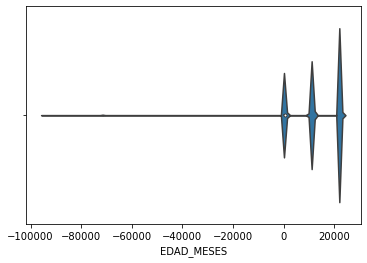

In [10]:
fig, ax = plt.subplots()
sns.violinplot(ax=ax,x=baseEnt['EDAD_MESES']);

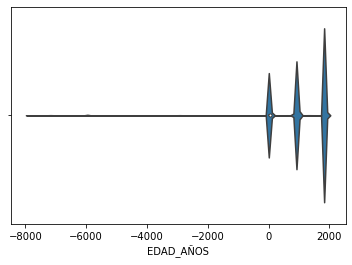

In [11]:
fig, ax = plt.subplots()
sns.violinplot(ax=ax,x=baseEnt['EDAD_AÑOS']);

###  procesar Identificación

In [12]:
def limpiarIdentificacion(dni):
    dni = re.sub(r'\W', ' ', str(dni))
    dni=dni.replace('.','')
    dni=dni.replace(' ','')
    return dni

In [13]:
def tipoDocumento(dni):    
    #text='9005514169.0'
    dni=str(dni)    
    #pos=dni.find('.')
    #if pos != -1:
    #    dni=dni[0:pos]    
    longitud=len(str(dni))
    if longitud==0:
        return "vacio"
    
    inicial=dni[0]
    respuesta="desconocido"
    #si tiene texto
    if any( (c.isalpha()) for c in dni):
        respuesta="conTexto"
    elif (longitud == 9 or longitud==10) and (inicial=='9' or inicial=='8'):
        respuesta="NIT"
    elif (longitud == 7 or longitud==8):
        respuesta="cedula"
    elif (longitud == 10) and (inicial=='1'):
        respuesta="cedula"
    elif longitud<=6:
        respuesta="sin id"
    return respuesta

In [14]:
baseEnt['id_limp']=baseEnt['IDENTIFICACION'].apply(limpiarIdentificacion)

In [15]:
baseEnt[baseEnt['IDENTIFICACION']=='>']

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp
2727334,>,599.581,49.965,


In [16]:
baseEnt['tipoID']=baseEnt['id_limp'].apply(tipoDocumento)

In [17]:
baseEnt['tipoID'].value_counts()

cedula         5640938
desconocido      39326
sin id           26091
NIT               3396
conTexto            58
vacio                2
Name: tipoID, dtype: int64

In [18]:
len(baseEnt)

5709811

In [19]:
baseEnt=baseEnt.drop_duplicates()

### quitar registros sin EDAD

In [20]:
baseEnt['EDAD_MESES'].isnull().sum()

27164

In [21]:
baseEnt=baseEnt[baseEnt['EDAD_MESES'].notnull()]

In [22]:
baseEnt['EDAD_MESES'].isnull().sum()

0

### Agregar Columnas a X

In [23]:
baseEnt['longitud']=baseEnt['id_limp'].str.len()

In [24]:
baseEnt.head()

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp,tipoID,longitud
0,52193919,562.871,46.906,52193919,cedula,8
1,1068974045,369.613,30.801,1068974045,cedula,10
2,1023968294,277.258,23.105,1023968294,cedula,10
3,79510526,630.323,52.527,79510526,cedula,8
4,11429424,741.226,61.769,11429424,cedula,8


In [25]:
baseEnt['num_ini']=baseEnt['id_limp'].str[:3]

In [26]:
baseEnt.head()

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp,tipoID,longitud,num_ini
0,52193919,562.871,46.906,52193919,cedula,8,521
1,1068974045,369.613,30.801,1068974045,cedula,10,106
2,1023968294,277.258,23.105,1023968294,cedula,10,102
3,79510526,630.323,52.527,79510526,cedula,8,795
4,11429424,741.226,61.769,11429424,cedula,8,114


## Muestras para entrenamiento, separación grupos

In [27]:
baseEntF=baseEnt[(baseEnt['tipoID']=='cedula') | (baseEnt['tipoID']=='sin id')]

In [28]:
baseEntF=baseEntF[(baseEntF['EDAD_AÑOS']>=5) &(baseEntF['EDAD_AÑOS']<=90)]

### Validar tipo

In [29]:
baseEntF['id_limp']=baseEntF['id_limp'].astype('int64')
baseEntF['num_ini']=baseEntF['num_ini'].astype('int64')

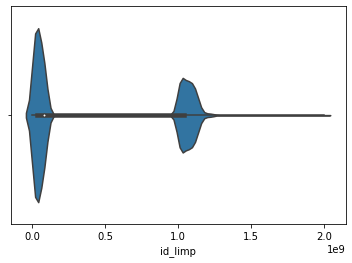

In [30]:
fig, ax = plt.subplots()
sns.violinplot(ax=ax,x=baseEntF['id_limp']);

In [31]:
baseEntF['cat_id']=np.where(
                            baseEntF['longitud']==10,'act2004', np.where(
                                baseEntF['id_limp']<20000000,'H1', np.where(
                                    baseEntF['id_limp']<70000000,'M1', np.where(
                                        baseEntF['id_limp']<100000000,'H2','rev')
                                    )
                                )
                )

In [32]:
baseEntF['cat_id'].value_counts()

act2004    2185292
M1         1635879
H1          934199
H2          849151
Name: cat_id, dtype: int64

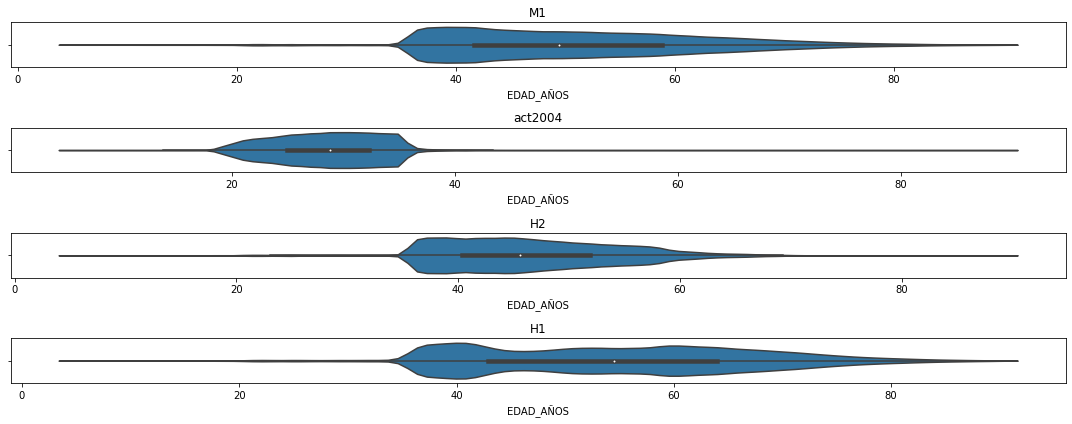

In [33]:
fig, ax = plt.subplots(4,1, figsize = (15, 6))
i=0
for cat in baseEntF['cat_id'].unique():
    sns.violinplot(ax=ax[i],x=baseEntF[baseEntF['cat_id']==cat]['EDAD_AÑOS']);
    ax[i].set_title(cat)
    i=i+1
plt.tight_layout()
plt.show()

###  Ubicar Anómalos

In [34]:
dicSinAnom={
        'M1':35,
        'H2':35,
        'H2':35,
        'act2004':35
}

In [35]:
baseEntF[baseEntF['cat_id']=='act2004'].describe()

,EDAD_MESES,EDAD_AÑOS,id_limp,longitud,num_ini
count,2185292.000,2185292.000,2185292.000,2185292.000,2185292.000
mean,343.963,28.664,1066940568.497,10.000,106.239
std,62.070,5.172,48177172.545,0.000,4.823
min,60.000,5.000,1000000032.000,10.000,100.000
25%,298.774,24.898,1023870406.750,10.000,102.000
50%,345.065,28.755,1064718815.000,10.000,106.000
75%,387.806,32.317,1100969829.000,10.000,110.000
max,1079.452,89.954,1999123456.000,10.000,199.000


In [36]:
baseEntF[baseEntF['cat_id']=='H1']['EDAD_AÑOS'].quantile(0.01)

27.69349462364167

In [37]:
df_H1=baseEntF[(baseEntF['cat_id']=='H1') &(baseEntF['EDAD_AÑOS']>=35)]
df_H2=baseEntF[(baseEntF['cat_id']=='H2') &(baseEntF['EDAD_AÑOS']>=35)]
df_M1=baseEntF[(baseEntF['cat_id']=='M1') &(baseEntF['EDAD_AÑOS']>=35)]
df_act2004=baseEntF[(baseEntF['cat_id']=='act2004') &(baseEntF['EDAD_AÑOS']<=35)]

In [38]:
##limpiar Memoria
#limpiar Memoria
del baseEntF
del baseEnt
#del modelo1
#del df_H1
gc.collect()

15

In [152]:
#usoMemoria()

In [ ]:
#scatter plots

<AxesSubplot:xlabel='id_limp', ylabel='EDAD_AÑOS'>

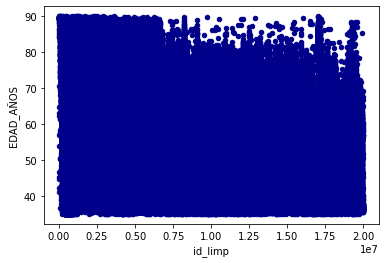

In [39]:
df_H1.plot.scatter(x='id_limp',y='EDAD_AÑOS',c='DarkBlue')

<AxesSubplot:xlabel='id_limp', ylabel='EDAD_AÑOS'>

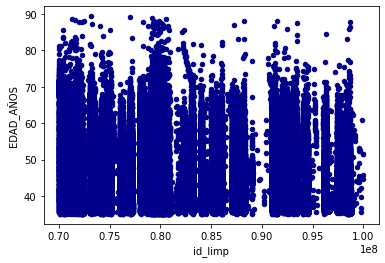

In [40]:
df_H2.plot.scatter(x='id_limp',y='EDAD_AÑOS',c='DarkBlue')

<AxesSubplot:xlabel='id_limp', ylabel='EDAD_AÑOS'>

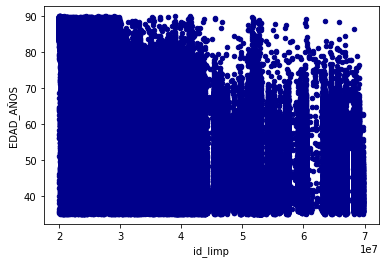

In [41]:
df_M1.plot.scatter(x='id_limp',y='EDAD_AÑOS',c='DarkBlue')

<AxesSubplot:xlabel='id_limp', ylabel='EDAD_AÑOS'>

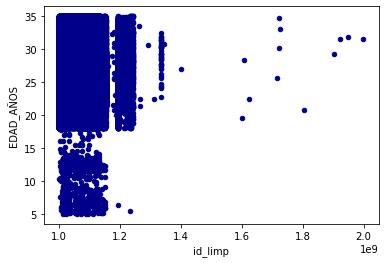

In [42]:
df_act2004.plot.scatter(x='id_limp',y='EDAD_AÑOS',c='DarkBlue')

## prueba modelos
* Arbol de desicion Reg
* RandomForest reg
* LGBMReg

* Prueba sin separar grupos

In [155]:
Xvar=df_H1[['id_limp','longitud','num_ini']]
yvar=df_H1['EDAD_AÑOS']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [157]:
modelo_H1=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)

In [158]:
modelo_H1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5)
#modelo_H1=modelo1

[0]	validation_0-rmse:53.61058	validation_1-rmse:53.59901
[1]	validation_0-rmse:51.49617	validation_1-rmse:51.48530
[2]	validation_0-rmse:49.46657	validation_1-rmse:49.45639
[3]	validation_0-rmse:47.51793	validation_1-rmse:47.50858
[4]	validation_0-rmse:45.64826	validation_1-rmse:45.63944
[5]	validation_0-rmse:43.85307	validation_1-rmse:43.84494
[6]	validation_0-rmse:42.12982	validation_1-rmse:42.12278
[7]	validation_0-rmse:40.47572	validation_1-rmse:40.46949
[8]	validation_0-rmse:38.88818	validation_1-rmse:38.88291
[9]	validation_0-rmse:37.36432	validation_1-rmse:37.36001
[10]	validation_0-rmse:35.90187	validation_1-rmse:35.89863
[11]	validation_0-rmse:34.49828	validation_1-rmse:34.49579
[12]	validation_0-rmse:33.15047	validation_1-rmse:33.14913
[13]	validation_0-rmse:31.85738	validation_1-rmse:31.85726
[14]	validation_0-rmse:30.61681	validation_1-rmse:30.61780
[15]	validation_0-rmse:29.42576	validation_1-rmse:29.42814
[16]	validation_0-rmse:28.28298	validation_1-rmse:28.28706
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=80,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=472, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

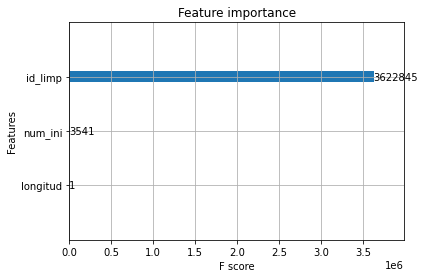

In [159]:
xgb.plot_importance(modelo_H1) 

In [165]:
data = {'id_limp': [19446953,19333333], 'longitud': [8,8], 'num_ini':[194,193]}
data =pd.DataFrame(data)

In [166]:
modelo_H1.predict(data)

array([60.06572, 62.01851], dtype=float32)

In [167]:
##guardarModelo
dump(modelo_H1,'modeloXGB_H1.pkl')

['modeloXGB_H1.pkl']

In [168]:
gc.collect()

288

In [169]:
#limpiar Memoria
#del baseEntF
#del baseEnt
#del modelo1
del df_H1
gc.collect()

15

### Modelos H2

In [170]:
Xvar=df_H2[['id_limp','longitud','num_ini']]
yvar=df_H2['EDAD_AÑOS']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [172]:
modelo_H2=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)

In [173]:
modelo_H2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5)

[0]	validation_0-rmse:45.01800	validation_1-rmse:45.01913
[1]	validation_0-rmse:43.22969	validation_1-rmse:43.23125
[2]	validation_0-rmse:41.51302	validation_1-rmse:41.51507
[3]	validation_0-rmse:39.86511	validation_1-rmse:39.86748
[4]	validation_0-rmse:38.28301	validation_1-rmse:38.28550
[5]	validation_0-rmse:36.76450	validation_1-rmse:36.76727
[6]	validation_0-rmse:35.30685	validation_1-rmse:35.30996
[7]	validation_0-rmse:33.90748	validation_1-rmse:33.91077
[8]	validation_0-rmse:32.56417	validation_1-rmse:32.56775
[9]	validation_0-rmse:31.27510	validation_1-rmse:31.27897
[10]	validation_0-rmse:30.03766	validation_1-rmse:30.04176
[11]	validation_0-rmse:28.84947	validation_1-rmse:28.85380
[12]	validation_0-rmse:27.70917	validation_1-rmse:27.71362
[13]	validation_0-rmse:26.61471	validation_1-rmse:26.61936
[14]	validation_0-rmse:25.56408	validation_1-rmse:25.56872
[15]	validation_0-rmse:24.55537	validation_1-rmse:24.56002
[16]	validation_0-rmse:23.58737	validation_1-rmse:23.59216
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=80,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=472, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

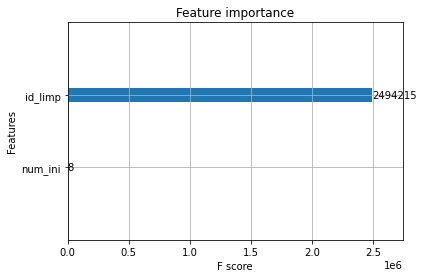

In [174]:
xgb.plot_importance(modelo_H2)

In [179]:
df_H2.sample(10)

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp,tipoID,longitud,num_ini,cat_id
2267044,83086033,773.903,64.492,83086033,cedula,8,830,H2
4791815,87061159,494.677,41.223,87061159,cedula,8,870,H2
1880248,80137400,471.903,39.325,80137400,cedula,8,801,H2
256040,80108780,480.097,40.008,80108780,cedula,8,801,H2
2223172,70098590,769.903,64.159,70098590,cedula,8,700,H2
3635034,98553725,608.419,50.702,98553725,cedula,8,985,H2
1437212,74380261,447.129,37.261,74380261,cedula,8,743,H2
2667069,7570840.000,465.258,38.772,75708400,cedula,8,757,H2
2517845,93116689,793.774,66.148,93116689,cedula,8,931,H2
5035878,80471492,588.710,49.059,80471492,cedula,8,804,H2


In [182]:
data = {'id_limp': [83086033,74380261,93116689,80471492], 'longitud': [8,8,8,8], 'num_ini':[830,743,931,804]}
data =pd.DataFrame(data)

In [183]:
modelo_H2.predict(data)

array([61.518417, 37.051365, 63.710423, 47.957462], dtype=float32)

In [184]:
dump(modelo_H2,'modeloXGB_H2.pkl')

['modeloXGB_H2.pkl']

In [185]:
del df_H2
gc.collect()

281

### Modelo M1

In [188]:
Xvar=df_M1[['id_limp','longitud','num_ini']]
yvar=df_M1['EDAD_AÑOS']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [190]:
modelo_M1=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)

In [191]:
modelo_M1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5)

[0]	validation_0-rmse:50.07126	validation_1-rmse:50.08179
[1]	validation_0-rmse:48.09192	validation_1-rmse:48.10224
[2]	validation_0-rmse:46.19236	validation_1-rmse:46.20267
[3]	validation_0-rmse:44.36908	validation_1-rmse:44.37969
[4]	validation_0-rmse:42.61877	validation_1-rmse:42.62929
[5]	validation_0-rmse:40.93866	validation_1-rmse:40.94927
[6]	validation_0-rmse:39.32583	validation_1-rmse:39.33654
[7]	validation_0-rmse:37.77771	validation_1-rmse:37.78867
[8]	validation_0-rmse:36.29172	validation_1-rmse:36.30284
[9]	validation_0-rmse:34.86529	validation_1-rmse:34.87659
[10]	validation_0-rmse:33.49625	validation_1-rmse:33.50794
[11]	validation_0-rmse:32.18214	validation_1-rmse:32.19419
[12]	validation_0-rmse:30.92076	validation_1-rmse:30.93307
[13]	validation_0-rmse:29.71006	validation_1-rmse:29.72271
[14]	validation_0-rmse:28.54822	validation_1-rmse:28.56158
[15]	validation_0-rmse:27.43304	validation_1-rmse:27.44694
[16]	validation_0-rmse:26.36316	validation_1-rmse:26.37779
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=80,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=472, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

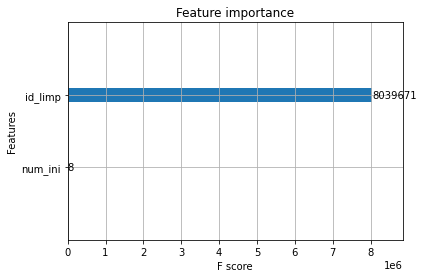

In [193]:
xgb.plot_importance(modelo_M1)

In [194]:
df_M1.sample(10)

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp,tipoID,longitud,num_ini,cat_id
4017248,21167489,844.935,70.411,21167489,cedula,8,211,M1
4220309,29508951,460.935,38.411,29508951,cedula,8,295,M1
2876064,37259321,782.258,65.188,37259321,cedula,8,372,M1
3862317,28846178,614.065,51.172,28846178,cedula,8,288,M1
3450810,41050022,713.742,59.478,41050022,cedula,8,410,M1
2146974,55068543,465.032,38.753,55068543,cedula,8,550,M1
5437361,29567345,767.903,63.992,29567345,cedula,8,295,M1
2198308,66827909,839.806,69.984,66827909,cedula,8,668,M1
4357164,24335779,438.484,36.540,24335779,cedula,8,243,M1
2385113,40383658,634.161,52.847,40383658,cedula,8,403,M1


In [195]:
data = {'id_limp': [41734923,51693316], 'longitud': [8,8], 'num_ini':[417,516]}

In [196]:
data =pd.DataFrame(data)

In [197]:
modelo_M1.predict(data)

array([64.07916 , 58.543053], dtype=float32)

In [198]:
dump(modelo_M1,'modeloXGB_M1.pkl')

['modeloXGB_M1.pkl']

In [199]:
del df_M1
gc.collect()

132

## Modelo act2004

In [202]:
Xvar=df_act2004[['id_limp','longitud','num_ini']]
yvar=df_act2004['EDAD_AÑOS']
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [203]:
modelo_act2004=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)
modelo_act2004.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5)

[0]	validation_0-rmse:26.66780	validation_1-rmse:26.66436
[1]	validation_0-rmse:25.61282	validation_1-rmse:25.60927
[2]	validation_0-rmse:24.60017	validation_1-rmse:24.59656
[3]	validation_0-rmse:23.62829	validation_1-rmse:23.62464
[4]	validation_0-rmse:22.69574	validation_1-rmse:22.69198
[5]	validation_0-rmse:21.80072	validation_1-rmse:21.79707
[6]	validation_0-rmse:20.94183	validation_1-rmse:20.93817
[7]	validation_0-rmse:20.11771	validation_1-rmse:20.11404
[8]	validation_0-rmse:19.32672	validation_1-rmse:19.32297
[9]	validation_0-rmse:18.56760	validation_1-rmse:18.56403
[10]	validation_0-rmse:17.83897	validation_1-rmse:17.83556
[11]	validation_0-rmse:17.14016	validation_1-rmse:17.13687
[12]	validation_0-rmse:16.46970	validation_1-rmse:16.46650
[13]	validation_0-rmse:15.82594	validation_1-rmse:15.82288
[14]	validation_0-rmse:15.20854	validation_1-rmse:15.20557
[15]	validation_0-rmse:14.61640	validation_1-rmse:14.61356
[16]	validation_0-rmse:14.04838	validation_1-rmse:14.04572
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=80,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=472, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

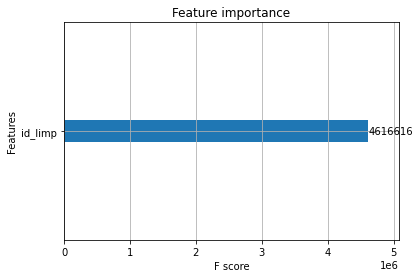

In [204]:
xgb.plot_importance(modelo_act2004)

In [205]:
df_act2004.sample(10)

,IDENTIFICACION,EDAD_MESES,EDAD_AÑOS,id_limp,tipoID,longitud,num_ini,cat_id
5234043,1010182748,386.419,32.202,1010182748,cedula,10,101,act2004
5213046,1026561711,381.935,31.828,1026561711,cedula,10,102,act2004
2582090,1152461788,292.742,24.395,1152461788,cedula,10,115,act2004
5230086,1118840604,352.581,29.382,1118840604,cedula,10,111,act2004
1524117,1063619725,390.387,32.532,1063619725,cedula,10,106,act2004
2162786,1012383246,355.032,29.586,1012383246,cedula,10,101,act2004
2501535,1032415322,403.258,33.605,1032415322,cedula,10,103,act2004
2615390,1036941260,358.613,29.884,1036941260,cedula,10,103,act2004
4483119,1001546106,280.452,23.371,1001546106,cedula,10,100,act2004
5591959,1116247687,272.484,22.707,1116247687,cedula,10,111,act2004


In [206]:
data = {'id_limp': [1022341429,1032379203], 'longitud': [10,10], 'num_ini':[1022,1032]}
data =pd.DataFrame(data)
modelo_act2004.predict(data)

array([33.333626, 34.167168], dtype=float32)

In [207]:
dump(modelo_act2004,'modeloXGB_act2004.pkl')
del df_act2004
gc.collect()

95

In [213]:
#del X_train
#del y_train
#del X_test
#del y_test
#del Xvar
#del yvar
gc.collect()

186

###  Recortes

In [ ]:
##  cedula mama  41734923
##  cedula mama fai 51693316
## cedula milton 1022341429
## cedula padre 19446953
## cedula prueba 80123456

In [33]:
#baseEntF=baseEntF.iloc[0:10]

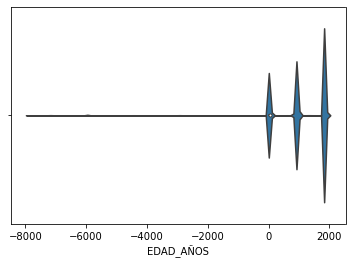

In [82]:
fig, ax = plt.subplots()
sns.violinplot(ax=ax,x=baseEntF['EDAD_AÑOS']);